# Setup

In [2]:
import numpy as np
import pylab as plt
from ipywidgets import interact

ground_truth = lambda x: x * np.sin(x*2)
def get_data(ground_truth, n_samples, noise=0.5):
    X = np.random.uniform(0, 6, n_samples)
    y = ground_truth(X) + np.random.randn(*X.shape)*noise
    return X, y

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Gaussian Processes

In this exercise, we will implement a Gaussian process for regession.

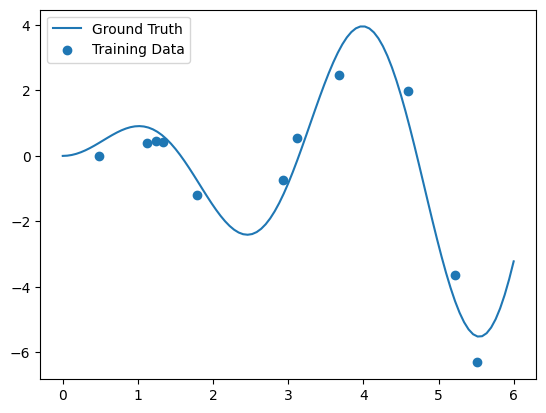

In [3]:
np.random.seed(5)
X, y = get_data(ground_truth, n_samples=11)
axis = np.linspace(0, 6, 101)

plt.plot(axis, ground_truth(axis), label='Ground Truth')
plt.scatter(X, y, label='Training Data')
plt.legend()
plt.show()

## Kernel functions
Implement the kernel functions which are defined below.

> Exponential Covariance (Equation 6.63): $$k(\mathbf{x}_n, \mathbf{x}_m)  = \theta_0 \exp\left( - \frac{\theta_1}{2} \Vert \mathbf{x}_n - \mathbf{x}_m \Vert^2 \right) + \theta_2 + \theta_3 \mathbf{x}_n^T\mathbf{x}_m.$$
> Exponential Kernel (Equation 6.56): $$k\left(x, x^{\prime}\right)=\exp \left(-\theta\left|x-x^{\prime}\right|\right)$$

In [4]:
class ExponentialCovariance:
    """Gaussian kernel from Eq. 6.63."""
    def __init__(self, theta0=1, theta1=1, theta2=0, theta3=0):
        self.theta0 = theta0
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3

    def __call__(self, x, y):
        x = np.array(x)
        y = np.array(y)
        return self.theta0 * np.exp(-0.5 * self.theta1 * np.linalg.norm(x - y)**2) \
            + self.theta2 \
            + self.theta3 * (x.T * y)

kernel = ExponentialCovariance()
kernel([2], [1]) # should return 0.6065306597126334

array([0.60653066])

In [5]:
class ExponentialKernel:
    """Exponential kernel from Eq. 6.56."""
    def __init__(self, theta=1):
        self.theta = theta

    def __call__(self, x, y):
        x = np.array(x)
        y = np.array(y)
        return np.exp(-self.theta * np.linalg.norm(x - y))
    
kernel = ExponentialKernel()
kernel([2], [1]) # should return 0.36787944117144233

0.36787944117144233

        Feel free to implement additional kernels from the lecture. They can be used in the resulting GP model.

## Prior Distribution

> Implment the class `GaussianProcess` with the following methods:
> - `__init__`: Initializes all hyperparameters of our model. In this case we need the corresponding kernel function we want to use.
> - `prior_samples`: Provides random samples from the prior distribution over functions.


In [6]:
class GaussianProcess:
    def __init__(self, kernel_func):
        self.kernel = kernel_func

    def prior_samples(self, X, n_samples):
        n = len(X)
        K = np.array([[self.kernel(x, y) for x in X] for y in X])
        return np.random.multivariate_normal(np.zeros(n), K, n_samples)

> Plot samples according to the figure on slide 18.

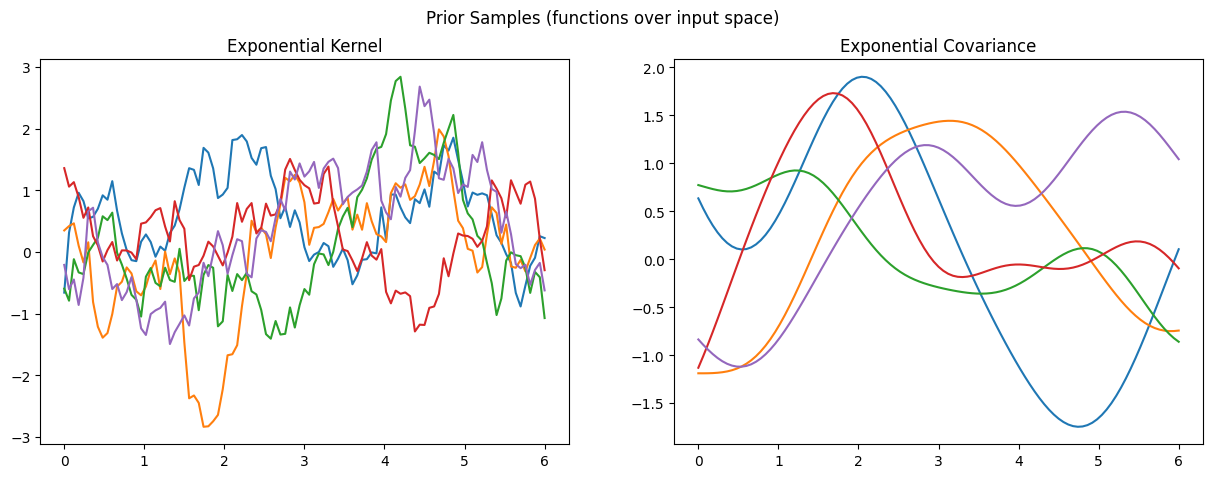

In [7]:
kernels = {
    'Exponential Kernel': ExponentialKernel(),
    'Exponential Covariance': ExponentialCovariance()
}

fig, axs = plt.subplots(1, len(kernels), figsize=(15, 5))
for i, (name, kernel) in enumerate(kernels.items()):
    gp = GaussianProcess(kernel)
    samples = gp.prior_samples(axis, 5)
    for sample in samples:
        axs[i].plot(axis, sample)
    axs[i].set_title(name)
fig.suptitle('Prior Samples (functions over input space)')
plt.show()

## Conditional distribution

Our ultimate goal is to find the predictive distribution. That is, we seek to evaluate  $p(t_{N+1}| \mathbf{t})$ for a new sample $\mathbf{x}_{N+1}$.
In order to find the conditional distribution $p(t_{N+1}| \mathbf{t})$:
1. We start by writing down the joint distribution $p(\mathbf{t}_{N+1})$, where $\mathbf{t}_{N+1}$ denotes the vector $(t_1,\ldots,t_N, t_{N+1})^T$.
2. We then apply the results from Section 2.3.1 to obtain the required conditional distribution.

### Joint Distribution
The joint distribution over $t_1, \ldots, t_{N+1}$ will be given by $$\quad p(\mathbf{t}_{N+1}) = \mathcal{N}(\mathbf{t}_{N+1}| \mathbf{0}, \mathbf{C}_{n+1})$$
where $\mathbf{C}_{N+1}$ is an $(N+1)\times(N+1)$ covariance matrix with elements given by $$\quad C\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)=k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)+\beta^{-1} \delta_{n m}$$
where $\beta$ is a hyperparameter representing the precision of the noise.
Because the joint distribution is Gaussian, we can apply the results from Section 2.3.1 to find the conditional Gaussian distribution. To do this, we partition the covariance matrix as follows
$$\quad \textbf{C}_{N+1} =  \left( \begin{array}{cc} \textbf{C}_{N} & \textbf{k}  \\ \textbf{k}^{T} & c  \\ \end{array} \right)$$ 
where $\mathbf{C}_N$ is the $N \times N$ covariance matrix, the vector $\mathbf{k}$ has elements $k(\mathbf{x}_n, \mathbf{x}_{N+1})$ for $n = 1,\ldots,N$, and the scalar $c = k(\mathbf{x}_{N+1}, \mathbf{x}_{N+1}) + \beta^{-1}$. We see that the conditional distribution $p(t_{N+1}|\mathbf{t})$ is a Gaussian distribution with mean and covariance given by
$$\quad m(\mathbf{x}_{N+1}) = \mathbf{k}^T \mathbf{C}_N^{-1}\mathbf{t} \quad \quad \sigma^2 (\mathbf{x}_{N+1}) =  c - \mathbf{k}^T\mathbf{C}_n^{-1}\mathbf{k}$$

The only restriction on the kernel function is that the covariance matrix must be positive definite. If $\lambda_i$ is an eigenvalue of $\mathbf{K}$, then the corresponding eigenvalue of $\mathbf{C}$ will be $\lambda_i + \beta^{-1}$.
It is therefore sufficient that the kernel matrrix $k(\mathbf{x}_n, \mathbf{x}_m)$ be positive semidefinite for any pair of points $\mathbf{x}_n$ and $\mathbf{x}_m$, so that $\lambda_i \geq 0$, because any eigenvalue $\lambda_i$ that is zero will still give rise to a positive eigenvalue for $\mathbf{C}$ because $\beta \ge 0$.

Note that the mean (6.66) of the predictive distribution can be written, as a function of $\mathbf{x}_{N+1}$, in the form  $$\quad m(\mathbf{x}_{N+1}) = \sum_{n=1}^{N} a_n k(\mathbf{x}_n \mathbf{x}_{N+1})$$ where $a_n$ is the $\text{n}^{\text{th}}$ component of $\mathbf{C}_N^{-1}\mathbf{t}$. Thus, if the kernel $k(\mathbf{x}_n, \mathbf{x}_m)$ depends only on the distance $\Vert \mathbf{x}_n - \mathbf{x}_m \Vert$, then we obtain an expansion on radial basis functions.
The results (6.66) and (6.67) define the predictive distribution for Gaussian process regression with an arbitrary kernel function $k(\mathbf{x}_n, \mathbf{x}_m)$.
> Implement the predict function based on Eq. 6.68 and extend this idea for the confidence sigma. Don't forget to extend previous functions to include the noise.

In [8]:
class GaussianProcess(GaussianProcess):
    def fit(self, X, y, noise=.1):
        self.noise = noise
        self.C = np.array([[self.kernel(x, y) for x in X] for y in X]) + noise * np.eye(len(X))
        self.X = X
        self.y = y

    def predict_conditional(self, inp):
        k = np.array([self.kernel(x, inp) for x in self.X])
        c = self.kernel(inp, inp) + self.noise
        mean = k.dot(np.linalg.solve(self.C, self.y))
        var = c - k.dot(np.linalg.solve(self.C, k))
        return mean, var

> Plot the predictions of the Gaussian Process with the corresponding dataset. Plot the standard deviation as done [here](https://stackoverflow.com/questions/45136420/filling-range-of-graph-in-matplotlib).

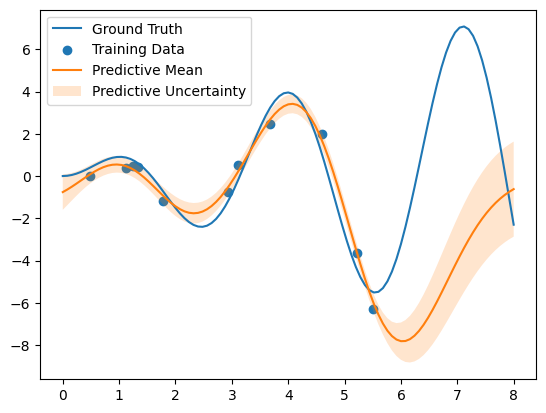

In [9]:
# reinitialize the axis
axis = np.linspace(0, 8, 101)

gp = GaussianProcess(ExponentialCovariance(theta0=5))
gp.fit(X, y)

pred_list = [gp.predict_conditional(x) for x in axis]
means, covs = zip(*pred_list)

plt.plot(axis, ground_truth(axis), label='Ground Truth')
plt.scatter(X, y, label='Training Data')
plt.plot(axis, means, label='Predictive Mean')
plt.fill_between(axis, means - np.sqrt(covs), means + np.sqrt(covs), alpha=0.2, label='Predictive Uncertainty')

plt.legend()
plt.show()

> Test your code with the following interactive plot and modify the parameters to be get an intuitive understanding for the behavior of the kernel.
> You might have to adapt the code if it is not working out of the box with your own implementation.

In [11]:
def plot_predict_conditional(noise=.2, theta0=1, theta1=1, theta2=0, theta3=0):
    kernel_func = ExponentialCovariance(theta0=theta0, theta1=theta1, theta2=theta2, theta3=theta3)
    gp = GaussianProcess(kernel_func)
    gp.fit(X, y, noise=noise)

    fig = plt.figure(figsize=(13, 5))
    axis = np.linspace(min(X)-2, max(X)+2, 101)

    preds = np.c_[[gp.predict_conditional(x) for x in axis]]
    mean_pred = preds[:, 0].flatten()
    var_pred = preds[:, 1].flatten()
    plt.plot(axis, mean_pred)
    plt.fill_between(axis, mean_pred - np.sqrt(var_pred), mean_pred + np.sqrt(var_pred), alpha=.3)
    plt.scatter(X, y)

interact(plot_predict_conditional,  noise=(0.01, 1, 0.01), theta0=(0, 5, .1), theta1=(0, 5, .1), theta2=(0, 5, .1), theta3=(0, 5, .1))
plt.show()

interactive(children=(FloatSlider(value=0.2, description='noise', max=1.0, min=0.01, step=0.01), FloatSlider(v…